#Demo de TF-Agents para ordenar elementos de una lista usando una red DQN


In [ ]:
#@title Instalar Paquete de TF-Agents
##!pip install -q tf-agents

# usar esta versión para evitar error 
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
!git checkout v0.13.0
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 22.3 MB/s 
     |████████████████████████████████| 18.3 MB 110 kB/s 
     |████████████████████████████████| 511.7 MB 5.1 kB/s 
     |████████████████████████████████| 6.5 MB 38.9 MB/s 
     |████████████████████████████████| 5.8 MB 46.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.1 MB/s 
     |████████████████████████████████| 438 kB 44.9 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully 

In [ ]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint
from sklearn import preprocessing
import copy

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

import os
from tf_agents.policies import policy_saver

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")

Librerías cargadas.


## Clases sobre el Problema a resolver

In [ ]:
#@title Definir las primitivas a usar para ordenar la lista

# intercambia valores de pos1 con pos2 
def intercambiar(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos1 >= len(lista)):
    if (pos1 < 0):
      pos1 = 0
    else:
      pos1 =  len(lista) - 1
  if (pos2 < 0) or (pos2 >= len(lista)):
    if (pos2 < 0):
      pos2 = 0
    else:
      pos2 =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if pos1 == pos2:
    return lista
  else:    
    # realiza el intercambio
    lista[pos1], lista[pos2] = lista[pos2], lista[pos1]
    return lista

# mueve el valor de posAnt a posNueva
def mover(lista, posAnt, posNueva):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (posAnt < 0) or (posAnt >= len(lista)):
    if (posAnt < 0):
      posAnt = 0
    else:
      posAnt =  len(lista) - 1
  if (posNueva < 0) or (posNueva >= len(lista)):
    if (posNueva < 0):
      posNueva = 0
    else:
      posNueva =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if posAnt == posNueva:
    return lista
  else:    
    # realiza el intercambio
    lista.insert(posNueva, lista.pop(posAnt))
    return lista

# función auxiliar para contar la cantidad de desordenados
# (debe ser de menor a mayor)
def contarDesordenados(lista):  
  cantError = 0
  if len(lista) > 0:
    i = 0 
    while i < len(lista):
      ant = lista[i]
      j = i + 1
      while j < len(lista):
        actual = lista[j]
        if actual < ant:
          cantError = cantError + 1
        j = j + 1      
      i = i + 1
  return cantError

# variable auxiliar para determinar máximo de acciones a probar antes de abortar
POSIBLES_ACCIONES_DESC = [ "mover", "intercambiar" ]
POSIBLES_ACCIONES = [ mover,  intercambiar ]

print("Primitivas de acciones definidas: ", POSIBLES_ACCIONES_DESC)

Primitivas de acciones definidas:  ['mover', 'intercambiar']


In [ ]:
#@title Definir Entorno del Problema 

# parámetros generales
MAX_ITERACIONES_REALIZAR = 100
MAX_ITERACIONES_ACCIONES_IGUALES = 4
TAMANIO_MINIMO_LISTA = 3
TAMANIO_MAXIMO_LISTA = 10
MAXIMO_VALOR_ACTION = ((len(POSIBLES_ACCIONES)-1)*100) + ((TAMANIO_MAXIMO_LISTA-1) * 10) + (TAMANIO_MAXIMO_LISTA-1)

def parsearAccion(action):
  # como DQN sólo permite 1 action numérica
  # esta función se ocupa de parsearla para determinar:
  #    tipo de acción
  #    param1
  #    param2
  aux = action
  idAccion = aux // 100
  aux = aux - idAccion * 100
  param1 = aux // 10
  aux = aux - param1 * 10
  param2 = aux
  #print(action, idAccion, param1, param2)
  return idAccion, param1, param2

# Un entorno que represente el juego podría verse así:
class OrdenarListasEnv(py_environment.PyEnvironment):

  def __init__(self, reGenerarReset=True):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=MAXIMO_VALOR_ACTION, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(TAMANIO_MAXIMO_LISTA,), dtype=np.float32, name='observation')      
    self._state = 0
    self._antAction = -1
    self._episode_ended = False
    self._reGenerarListaReset = reGenerarReset
    if self._reGenerarListaReset:
      # inicializa vacía porque se define en el reset
      self._listaOriginal = []
    else:
      # la lista se define sólo al principio, luego se vuelve a desordenar
      self._listaOriginal = self.crearLista()
    self._lista = []

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def render(self, mode = 'human'):
    # devuelve la lista para mostsrar
    return np.array(self._lista, dtype=np.int32)

  def _reset(self):
    # resetea el entorno
    if self._reGenerarListaReset:
      # cada vez que se reseta, se define la lista
      self._listaOriginal = self.crearLista()
    # siempre la lista de trabajo se copia de la original
    self._lista = copy.deepcopy( self._listaOriginal ) 
    # actualiza el estado considerando cantidad de ordenados
    self.actualizarEstado()
    self._cantIteraciones = 0
    self._episode_ended = False
    self._antAction = []
    return ts.restart(self.devolverObsActual())

  def crearLista(self):
    # genera los valores de las listas al azar
    cantElemRnd = randint(TAMANIO_MINIMO_LISTA, TAMANIO_MAXIMO_LISTA)
    #cantElemRnd = TAMANIO_MAXIMO_LISTA
    lista = []
    for j in range(cantElemRnd): 
      lista.append( randint(-99, 99) )
    return lista

  def actualizarEstado(self):
    # actualiza el valor del estado del entorno
    # teniendo en cuenta la cantidad de errores negativos
    self._state = - contarDesordenados(self._lista)
    return self._state

  def devolverObsActual(self):
    # devuelve valores para la observación actual
    # los valores de la lista (rellenando con cero)
    # para que el agente sepa el estado real del entorno
    res = []
    res.extend( self._lista )
    val = 100
    while (len(res) < TAMANIO_MAXIMO_LISTA):
      res.append( val )
      val = val + 1
    # nota: para DQN parece ser que conviene 
    # normalizar los valores para que sean más homogeneos 
    # y no demasiado dispares entre sí 
    # (sino genera un 'loss' demasiado grande)
    r = (res - np.min(res)) / (np.max(res) - np.min(res))
    return  np.array([round(v,3) for v in r], dtype=np.float32)

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()

    # actualiza cantidad de interacciones 
    self._cantIteraciones = self._cantIteraciones - 1

    # parsea la accion para determinar acción con sus parámetros
    idAccion, param1, param2 = parsearAccion(action)

    # si es un id de acción válida
    if idAccion >= 0 and idAccion < len(POSIBLES_ACCIONES):
      # aplica la acción correspondiente en cada lista
      # y calculando la cantidad de desordenados como error
      self._lista = POSIBLES_ACCIONES[idAccion](self._lista, param1, param2)
      
      # actualiza el estado con la cantidad de valores correctos
      self.actualizarEstado()

      # controla que no sea una acción repetida
      # de forma que si empieza a repetir más de una cantidad máxima
      # finaliza la operatoria
      i = 0
      cantActionIguales = 0 
      while i < len(self._antAction):
        if self._antAction[i] == action:
          cantActionIguales = cantActionIguales + 1
        i = i + 1             
      # siempre mantiene 3 (saca la más vieja)
      # y agrega la nueva
      if len(self._antAction) >= MAX_ITERACIONES_ACCIONES_IGUALES:
        self._antAction.pop( 0 )
      self._antAction.append( action )

    # determina si debe finalizar o no
    if (self._state == 0) or (abs(self._cantIteraciones) >= abs(MAX_ITERACIONES_REALIZAR)) or (cantActionIguales >= MAX_ITERACIONES_ACCIONES_IGUALES):
      # si está todo ordenado 
      # o si la cantidad de iteraciones llega al límite
      # o se repitió muchas veces la misma action
      # fuerza que finaliza
      self._episode_ended = True

    if self._episode_ended:
      # si finaliza
      # devuelve el reward (siempre se maximiza):
      # si logra ordenar
      # se calcula penalizando la cantidad de iteraciones 
      if (self._state == 0):
        reward = MAX_ITERACIONES_REALIZAR + self._cantIteraciones
      else:
        reward = self._state
      return ts.termination(self.devolverObsActual(), reward)
    else:
      # si no finaliza
      reward = self._state
      return ts.transition(
         self.devolverObsActual(), reward=self._state, discount=0.9)
         # notar que no se usa discount=1.0 porque sino genera problema de 'loss' muy grande

print("\nEntorno del Problema definido.")

# Definir entornos de entrenamiento y de evaluación
# (ambos con lista que se cambia cada vez que se resetea)
train_py_env = OrdenarListasEnv(True)
eval_py_env = OrdenarListasEnv(True)

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("\nEntornos de entrenamiento y prueba definidos. ")

# definir simulador para probar el entorno
def SimularEntorno(env, policy, titulo, mostrarDetalle=True):
    print("\n** ", titulo, "**")                   
    # muesta estado inicial
    time_step = env.reset()      
    #ob = time_step.observation.numpy()[0]
    if mostrarDetalle:
      print(" Ini: [", time_step, "]")    
    print(" Lista Inicial = ", env.pyenv.render()[0] )
    j = 1
    while not time_step.is_last():
      # la política determina la acción a realizar
      action_step = policy.action(time_step)
      time_step = env.step(action_step.action)
      # recupera la observación y muestra el nuevo estado 
      ac = action_step.action.numpy()[0]
      idAccion, param1, param2 = parsearAccion(ac)
      r = time_step.reward.numpy()[0]
      ##ob = time_step.observation.numpy()[0]
      descAccion = "acción " +  POSIBLES_ACCIONES_DESC[ idAccion ] + "(" + str(param1) + "," + str(param2) + ")"
      if mostrarDetalle:
        print("  #", j, ":", descAccion, "-> Estado/Reward ", r, "[", time_step, ",", action_step, "]")
      else:
        print("  #", j, ":", descAccion, "-> Estado/Reward ", r)
      ### print("    Lista = ", env.pyenv.render()[0] )
      j = j + 1
    # muestra estado final
    print(" Recompensa Final = ", r )
    print(" Lista Final = ", env.pyenv.render()[0] )
    return r

print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
MostrarDetalleSteps = False #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema con política al azar", MostrarDetalleSteps)




Entorno del Problema definido.

Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema con política al azar **
 Lista Inicial =  [ 36 -96 -38 -75]
  # 1 : acción mover(4,8) -> Estado/Reward  -4.0
  # 2 : acción mover(4,9) -> Estado/Reward  -4.0
  # 3 : acción intercambiar(2,4) -> Estado/Reward  -3.0
  # 4 : acción intercambiar(8,4) -> Estado/Reward  -3.0
  # 5 : acción mover(3,8) -> Estado/Reward  -3.0
  # 6 : acción mover(4,8) -> Estado/Reward  -3.0
  # 7 : acción mover(5,8) -> Estado/Reward  -3.0
  # 8 : acción mover(6,1) -> Estado/Reward  -5.0
  # 9 : acción intercambiar(9,4) -> Estado/Reward  -5.0
  # 10 : acción intercambiar(7,8) -> Estado/Reward  -5.0
  # 11 : acción mover(6,8) -> Estado/Reward  -5.0
  # 12 : acción mover(1,3) -> Estado/Reward  -3.0
  # 13 : acción intercambiar(8,1) -> Estado/Reward  -6.0
  # 14 : acción mover(3,1) -> Estado/Reward  -4.0
  # 15 : acción intercambiar(0,2) -> Estado/Reward  -3.0
  # 16 

##DQN

In [ ]:
#@title Definir el Agente tipo DQN
entrenar_DQN = True # @param {type:"boolean"}
DQNpolicy = None

if entrenar_DQN:
  tipo_agente = "DQN" #@param ["DQN", "DQN Categorico (C51)"]
  learning_rate = 1e-3  # @param {type:"number"}
  cant_neuronas_ocultas = "100, 50, 25" # @param {type:"string"}
  DQNCat_num_atoms = 51  # param {type:"integer"}

  # controla cantidad de atoms para DQN Cat
  if DQNCat_num_atoms <= 1:
    DQNCat_num_atoms = 51

  # Define cantidad de neuronas ocultas para RNA-Q
  hidden_layers = []
  for val in cant_neuronas_ocultas.split(','):
    if  int(val) < 1:
      hidden_layers.append( 10 )
    else:
      hidden_layers.append( int(val) )
  fc_layer_params = tuple(hidden_layers, )

  if tipo_agente=="DQN":

    #define las capas convolutional
    CNN_preprocessing_layers = None

    # Define RNA-Q
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.Variable(0)

    # Define el agente de tipo Q
    ag = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

    ag.initialize()

    print("Agente DQN inicializado. ")

  elif tipo_agente == "DQN Categorico (C51)":
    
    # Define RNA-Q Categórico
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=DQNCat_num_atoms,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)
    
    # parámetros especificos (por defecto)
    n_step_update = 2
    gamma = 0.99

    # Define el agente de tipo Q Categórico
    ag = CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter)
    
    ag.initialize()
    
    print("Agente DQN Categorico (C51) inicializado. ")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  

Agente DQN inicializado. 


In [ ]:
#@title Métricas para evaluación y Preparar datos para Entrenamiento del Agente DQN

if entrenar_DQN:

  # Definir Métricas para evaluación para Agente DQN
    
  # Se usa el promedio de la recompensa (la más común)
  # See also the metrics module for standard implementations of different metrics.
  # https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

  def compute_avg_return(environment, policy, num_episodes=10):
    if num_episodes == 0:
      return 0.0 
    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

  initial_collect_steps = 1000  # @param {type:"integer"} 
  collect_steps_per_iteration =   50# @param {type:"integer"}
  replay_buffer_max_length = 100000  # @param {type:"integer"}
  batch_size = 64  # @param {type:"integer"}

  # Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec = ag.collect_data_spec,
      batch_size = train_env.batch_size,
      max_length = replay_buffer_max_length)

  # Recolecta datos generados al azar
  # This loop is so common in RL, that we provide standard implementations. 
  # For more details see the drivers module.
  # https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

  def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

  def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
      collect_step(env, policy, buffer)

  collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

  print("\nDatos recolectados.")

  # Muestra ejemplo de los datos recolectados
  ##iter(replay_buffer.as_dataset()).next()

  # Preparar los datos recolectados con trajectories de shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, 
      sample_batch_size=batch_size, 
      num_steps=2).prefetch(3)
  iterator = iter(dataset)
  # Muestra ejemplo 
  ##iterator.next()
  print("\nDataset creado.")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  


Datos recolectados.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.

Dataset creado.


In [ ]:
#@title Entrenar al Agente DQN

if entrenar_DQN:

  cant_ciclos_entrenamiento_finalizar =  5000# @param {type:"integer"}
  log_cada_ciclos = 200  # @param {type:"integer"}
  mostar_recompensa_cada = 500  # @param {type:"integer"}
  cant_episodios_evaluacion =  10# @param {type:"integer"}
  minima_recompensa_promedio_finalizar = 100.0 # @param {type:"number"}
  
  #  Optimize by wrapping some of the code in a graph using TF function (Optional)
  ag.train = common.function(ag.train)

  # Reset the train step
  ag.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
  ar_cicloL = []
  ar_cicloR = []
  ar_returns = []
  ar_loss = []

  print("\n** Comienza el Entrenamiento **\n")
  for _ in range(cant_ciclos_entrenamiento_finalizar):

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = ag.train(experience).loss

    step = ag.train_step_counter.numpy()

    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % log_cada_ciclos == 0):
      print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
      ar_cicloL.append( step )
      ar_loss.append( train_loss )
    
    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % mostar_recompensa_cada == 0):
      avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
      ar_cicloR.append( step )
      ar_returns.append( avg_return )
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

      if (avg_return >= minima_recompensa_promedio_finalizar):
        print('** Finaliza en step {0} por buen valor de recompensa promedio: {1:.1f}'.format(step, avg_return)) 
        break

  DQNpolicy = ag.policy
  print("\n** Entrenamiento Finalizado **\n")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  


** Comienza el Entrenamiento **

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1: loss = 215.039
step = 1: Promedio Recompensa = -40.5
step = 200: loss = 48.228
step = 400: loss = 68.358
step = 500: Promedio Recompensa = -14.8
step = 600: loss = 452.685
step = 800: loss = 81.353
step = 1000: loss = 316.531
step = 1000: Promedio Recompensa = -0.4
step = 1200: loss = 127.896
step = 1400: loss = 369.399
step = 1500: Promedio Recompensa = -35.5
step = 1600: loss = 60.507
step = 1800: loss = 72.910
step = 2000: loss = 106.646
step = 2000: Promedio Recompensa = -61.7
step = 2200: loss = 235.739
step = 2400: loss = 80.180
step = 2500: Promedio Recompensa = -21.0
step = 2600: loss = 84.826
step = 2800: loss = 41.046
step = 3000: loss = 149.810
step = 3000: Promedio Recompensa = -74.0
step = 3200: loss

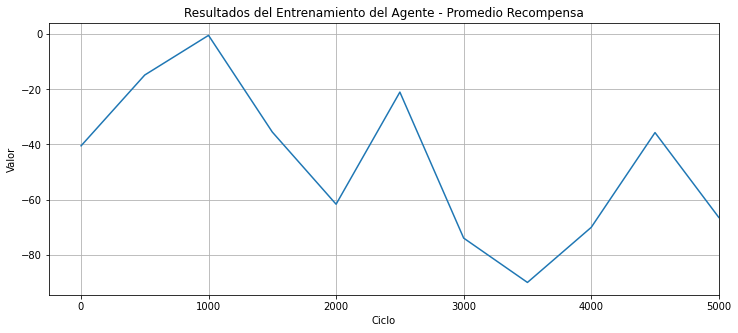

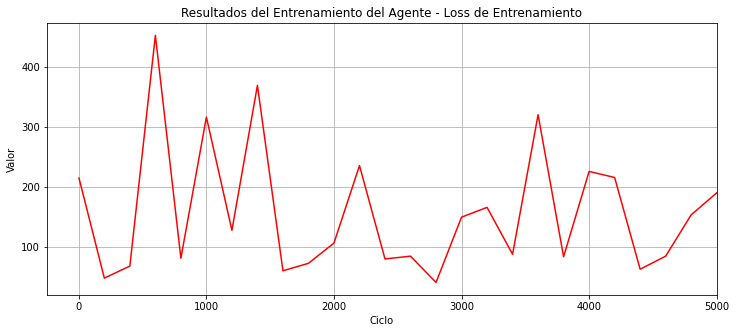

In [ ]:
#@title Mostrar Gráficos del Entrenamiento del Agente DQN


if entrenar_DQN:

  plt.figure(figsize=(12,5)) 
  plt.plot( ar_cicloR, ar_returns)
  plt.title("Resultados del Entrenamiento del Agente - Promedio Recompensa")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloR))   
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12,5)) 
  plt.plot( ar_cicloL, ar_loss, color="red" )
  plt.title("Resultados del Entrenamiento del Agente - Loss de Entrenamiento")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloL))   
  plt.grid(True)
  plt.show()


In [ ]:
#@title Probar el Agente DQN Entrenado contra el Azar
cantidad_probar = 10 # @param {type:"integer"}

if DQNpolicy is not None:
  for i in range(cantidad_probar):
    print("\n Prueba: ", i+1)
    SimularEntorno(eval_env, DQNpolicy, "Probando el Agente DQN entrenado contra azar", False)
    


 Prueba:  1

**  Probando el Agente DQN entrenado contra azar **
 Lista Inicial =  [ 88 -39 -46  40 -14 -68  30]
  # 1 : acción mover(0,6) -> Estado/Reward  -7.0
  # 2 : acción mover(3,4) -> Estado/Reward  -6.0
  # 3 : acción mover(3,4) -> Estado/Reward  -7.0
  # 4 : acción mover(3,4) -> Estado/Reward  -6.0
  # 5 : acción mover(3,4) -> Estado/Reward  -7.0
  # 6 : acción mover(3,4) -> Estado/Reward  -6.0
 Recompensa Final =  -6.0
 Lista Final =  [-39 -46  40 -68 -14  30  88]

 Prueba:  2

**  Probando el Agente DQN entrenado contra azar **
 Lista Inicial =  [ 90 -49  57 -13 -16 -30]
  # 1 : acción mover(0,5) -> Estado/Reward  -6.0
  # 2 : acción mover(3,4) -> Estado/Reward  -5.0
  # 3 : acción mover(3,4) -> Estado/Reward  -6.0
  # 4 : acción mover(3,4) -> Estado/Reward  -5.0
  # 5 : acción mover(3,4) -> Estado/Reward  -6.0
  # 6 : acción mover(3,4) -> Estado/Reward  -5.0
 Recompensa Final =  -5.0
 Lista Final =  [-49  57 -13 -30 -16  90]

 Prueba:  3

**  Probando el Agente DQN entrena

In [ ]:
#@title Cargar o Guardar los Agentes
# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoRL/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "policy-OrdenarLista" #@param {type:"string"}
accion_realizar = "Grabar Modelo" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

if accion_realizar != "-":
  import os
  from google.colab import drive
  from tf_agents.policies import TFPolicy, policy_saver
  # determina lugar donde se guarda el modelo
  policy_dir = os.path.join(directorio_modelo, nombre_modelo_grabar)
  ##qlCSV = policy_dir + "/QM-QLearning.csv"
  # Montar Drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  if (DQNpolicy is not None) and isinstance(DQNpolicy, TFPolicy):
    # guarda la politica del agente DQN entrenado
    tf_policy_saver = policy_saver.PolicySaver(DQNpolicy)
    tf_policy_saver.save(policy_dir)
    print("\nPolítica DQN guardada en ", policy_dir)
  ##if ql_policy is not None:
  ##  ql_policy.saveQ(qlCSV)
  ##  print("\nPolítica Q-Learning guardada en ", qlCSV)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  DQNpolicy = tf.compat.v2.saved_model.load(policy_dir)
  print("\nPolítica DQN recuperada de ", policy_dir)
  ##ql_policy.loadQ(qlCSV)
  ##print("\nPolítica Q-Learning recuperada de ", qlCSV)


Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-OrdenarLista/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-OrdenarLista/assets



Política DQN guardada en  /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-OrdenarLista
